In [1]:
!pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/


In [5]:
!kaggle competitions download -c spaceship-titanic

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 122MB/s]


In [6]:
!unzip /content/spaceship-titanic.zip

Archive:  /content/spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Read the data
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# Convert column names to lowercase
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

# Extract 'group' feature from passengerid
train_df['group'] = train_df['passengerid'].apply(lambda x: x.split('_')[0])
test_df['group'] = test_df['passengerid'].apply(lambda x: x.split('_')[0])

# Extract 'groupsize' feature
train_df['groupsize'] = train_df['group'].apply(lambda x: train_df['group'].value_counts()[x])
test_df['groupsize'] = test_df['group'].apply(lambda x: test_df['group'].value_counts()[x])

# Create 'solo' label column
train_df['solo'] = train_df['groupsize'].apply(lambda x: 1 if x == 1 else 0)
test_df['solo'] = test_df['groupsize'].apply(lambda x: 1 if x == 1 else 0)

# Extract features from cabin
def deck(x):
    try:
        return x.split('/')[0]
    except:
        pass

def num(x):
    try:
        return int(x.split('/')[1])
    except:
        pass

def side(x):
    try:
        return x.split('/')[2]
    except:
        pass

train_df['cabin_deck'] = train_df['cabin'].apply(deck)
train_df['cabin_num'] = train_df['cabin'].apply(num)
train_df['cabin_side'] = train_df['cabin'].apply(side)

test_df['cabin_deck'] = test_df['cabin'].apply(deck)
test_df['cabin_num'] = test_df['cabin'].apply(num)
test_df['cabin_side'] = test_df['cabin'].apply(side)

# Calculate 'spending' feature
train_df['spending'] = train_df[['roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck']].sum(axis=1)
test_df['spending'] = test_df[['roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck']].sum(axis=1)

# Join train and test datasets temporarily
train_df['train'] = 'Yes'
test_df['train'] = 'No'
df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Impute missing values
df[['roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck']] = df[['roomservice', 'foodcourt', 'shoppingmall', 'spa', 'vrdeck']].fillna(0)
df['age'] = df['age'].fillna(df['age'].median())
df['vip'] = df['vip'].fillna(False)
df['homeplanet'] = df['homeplanet'].fillna('Mars')
df['destination'] = df['destination'].fillna('TRAPPIST-1e')
df['cryosleep'] = df['cryosleep'].fillna(False)
df['cabin_deck'] = df['cabin_deck'].fillna('T')
df['cabin_num'] = df['cabin_num'].fillna('0')
df['cabin_side'] = df['cabin_side'].fillna('P')

# Create 'agegroup' label column
df['agegroup'] = pd.cut(df['age'], bins=[-1, 5, 13, 18, 60, 100], labels=['Baby', 'Child', 'Teen', 'Adult', 'Elderly'])

# Drop unnecessary columns
df = df.drop(['name', 'cabin', 'group'], axis=1)

# Encode categorical columns
categorical_cols = ['homeplanet', 'cryosleep', 'destination', 'vip', 'cabin_deck', 'cabin_side', 'cabin_num', 'agegroup']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Split back into train and test datasets
df_train = df[df['train'] == 'Yes']
df_test = df[df['train'] == 'No'].drop('transported', axis=1)

# Set passengerid as index
df_train.set_index('passengerid', inplace=True)

# Drop 'train' column
df_train.drop('train', axis=1, inplace=True)

# Label encode target variable
df_train['transported'] = df_train['transported'].replace({True: 1, False: 0})

# Split train data into features and target
X = df_train.drop('transported', axis=1)
y = df_train['transported']

# Split train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)



<ipython-input-7-c38e75a68c30>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('train', axis=1, inplace=True)
<ipython-input-7-c38e75a68c30>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['transported'] = df_train['transported'].replace({True: 1, False: 0})


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

# Read the data and preprocess as before

# Split train data into features and target
X = df_train.drop('transported', axis=1)
y = df_train['transported']

# Split train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Define parameter grid for MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32)],
    'activation': ['relu', 'tanh']
}

# Create an MLP model
mlp = MLPClassifier(random_state=1)

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(mlp, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Retrieve the best MLP model
mlp = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Train the best model
mlp.fit(X_train, y_train)

# Make predictions on validation set
y_val_pred = mlp.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Apply boosting algorithms
xgb = XGBClassifier()
lgbm = LGBMClassifier()
catboost = CatBoostClassifier()

xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# Create the ensemble model using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        #('mlp', mlp),
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('catboost', catboost)
    ],
    voting='hard'  # Use 'hard' for majority voting or 'soft' for weighted average
)

# Fit the ensemble model on the training data
ensemble_model.fit(X_train, y_train)

# Make predictions on validation set using the ensemble model
ensemble_pred = ensemble_model.predict(X_val)

# Calculate accuracy of the ensemble model
ensemble_accuracy = accuracy_score(y_val, ensemble_pred)
print("Ensemble Accuracy:", ensemble_accuracy)


Best Hyperparameters:
{'activation': 'tanh', 'hidden_layer_sizes': (128,)}
Validation Accuracy: 0.7935595169637722
Learning rate set to 0.023581
0:	learn: 0.6819650	total: 4.21ms	remaining: 4.21s
1:	learn: 0.6713136	total: 8.08ms	remaining: 4.03s
2:	learn: 0.6615567	total: 11.9ms	remaining: 3.95s
3:	learn: 0.6523721	total: 15.7ms	remaining: 3.92s
4:	learn: 0.6441136	total: 19.7ms	remaining: 3.93s
5:	learn: 0.6350249	total: 23.6ms	remaining: 3.92s
6:	learn: 0.6267612	total: 27.7ms	remaining: 3.93s
7:	learn: 0.6193852	total: 31.8ms	remaining: 3.95s
8:	learn: 0.6126354	total: 35.8ms	remaining: 3.94s
9:	learn: 0.6051789	total: 39.8ms	remaining: 3.94s
10:	learn: 0.5987361	total: 43.9ms	remaining: 3.95s
11:	learn: 0.5927996	total: 48ms	remaining: 3.95s
12:	learn: 0.5871341	total: 53.6ms	remaining: 4.07s
13:	learn: 0.5819250	total: 57.4ms	remaining: 4.04s
14:	learn: 0.5763564	total: 61.3ms	remaining: 4.02s
15:	learn: 0.5705320	total: 65ms	remaining: 4s
16:	learn: 0.5655832	total: 68.8ms	remai

In [ ]:
!pip install catboost

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier



# Creating the boosting classifiers
xgb = XGBClassifier()
lgbm = LGBMClassifier()
adaboost = AdaBoostClassifier()
catboost = CatBoostClassifier()

# Training the boosting classifiers
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
adaboost.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# Making predictions on the validation set
xgb_pred = xgb.predict(X_val)
lgbm_pred = lgbm.predict(X_val)
adaboost_pred = adaboost.predict(X_val)
catboost_pred = catboost.predict(X_val)

# Ensemble the classifiers using VotingClassifier
voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('lgbm', lgbm), ('adaboost', adaboost), ('catboost', catboost)], voting='hard')
voting_clf.fit(X_train, y_train)

# Making predictions using the ensemble model
ensemble_pred = voting_clf.predict(X_val)

# Evaluating the performance of individual models
print("XGBoost Accuracy:", accuracy_score(y_val, xgb_pred))
print("LightGBM Accuracy:", accuracy_score(y_val, lgbm_pred))
print("AdaBoost Accuracy:", accuracy_score(y_val, adaboost_pred))
print("CatBoost Accuracy:", accuracy_score(y_val, catboost_pred))

# Evaluating the performance of the ensemble model
print("Ensemble Accuracy:", accuracy_score(y_val, ensemble_pred))


Learning rate set to 0.023581
0:	learn: 0.6819650	total: 51ms	remaining: 51s
1:	learn: 0.6713136	total: 55.1ms	remaining: 27.5s
2:	learn: 0.6615567	total: 59ms	remaining: 19.6s
3:	learn: 0.6523721	total: 63.2ms	remaining: 15.7s
4:	learn: 0.6441136	total: 67.4ms	remaining: 13.4s
5:	learn: 0.6350249	total: 71.4ms	remaining: 11.8s
6:	learn: 0.6267612	total: 75.4ms	remaining: 10.7s
7:	learn: 0.6193852	total: 79.2ms	remaining: 9.83s
8:	learn: 0.6126354	total: 83.2ms	remaining: 9.16s
9:	learn: 0.6051789	total: 87.2ms	remaining: 8.63s
10:	learn: 0.5987361	total: 91.2ms	remaining: 8.2s
11:	learn: 0.5927996	total: 94.8ms	remaining: 7.81s
12:	learn: 0.5871341	total: 98.9ms	remaining: 7.5s
13:	learn: 0.5819250	total: 103ms	remaining: 7.23s
14:	learn: 0.5763564	total: 107ms	remaining: 7s
15:	learn: 0.5705320	total: 111ms	remaining: 6.79s
16:	learn: 0.5655832	total: 114ms	remaining: 6.61s
17:	learn: 0.5598754	total: 118ms	remaining: 6.44s
18:	learn: 0.5552232	total: 122ms	remaining: 6.3s
19:	learn:

In [22]:
!pip install xgboost

In [106]:
params_XGB_best= {'lambda': 3.0610042624477543,
             'alpha': 4.581902571574289,
             'colsample_bytree': 0.9241969052729379,
             'subsample': 0.9527591724824661,
             'learning_rate': 0.06672065863100594,
             'n_estimators': 730, #initial value is 651
             'max_depth': 5,
             'min_child_weight': 1,
             'num_parallel_tree': 1}
testmodel = xgb.XGBClassifier(**params_XGB_best)
testmodel.fit(X_train, y_train)
#Average n_ite=661

In [24]:
import xgboost as xgb
from xgboost import XGBClassifier

In [27]:
testmodel = xgb.XGBClassifier(**params_XGB_best)
testmodel.fit(X_train, y_train)


XGBClassifier(alpha=4.581902571574289, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9241969052729379, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=3.0610042624477543,
              learning_rate=0.06672065863100594, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=730, n_jobs=None, num_parallel_tree=1, ...)

In [44]:

testmodel = xgb.XGBClassifier(**params_XGB_best)
lgbm = LGBMClassifier()
catboost = CatBoostClassifier()

# Training the boosting classifiers
testmodel.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# Making predictions on the validation set
xgb_pred = testmodel.predict(X_val)
lgbm_pred = lgbm.predict(X_val)
catboost_pred = catboost.predict(X_val)

# Ensemble the classifiers using VotingClassifier
voting_clf = VotingClassifier(estimators=[('xgb', testmodel), ('lgbm', lgbm), ('catboost', catboost)], voting='hard')
voting_clf.fit(X_train, y_train)

# Making predictions using the ensemble model
ensemble_pred = voting_clf.predict(X_val)

# Evaluating the performance of individual models
print("XGBoost Accuracy:", accuracy_score(y_val, xgb_pred))
print("LightGBM Accuracy:", accuracy_score(y_val, lgbm_pred))
print("CatBoost Accuracy:", accuracy_score(y_val, catboost_pred))

# Evaluating the performance of the ensemble model
print("Ensemble Accuracy:", accuracy_score(y_val, ensemble_pred))


Learning rate set to 0.023581
0:	learn: 0.6819650	total: 4.18ms	remaining: 4.18s
1:	learn: 0.6713136	total: 8.26ms	remaining: 4.12s
2:	learn: 0.6615567	total: 12.2ms	remaining: 4.06s
3:	learn: 0.6523721	total: 16.6ms	remaining: 4.12s
4:	learn: 0.6441136	total: 20.4ms	remaining: 4.05s
5:	learn: 0.6350249	total: 24.2ms	remaining: 4s
6:	learn: 0.6267612	total: 29.7ms	remaining: 4.21s
7:	learn: 0.6193852	total: 33.5ms	remaining: 4.15s
8:	learn: 0.6126354	total: 38.2ms	remaining: 4.2s
9:	learn: 0.6051789	total: 42.1ms	remaining: 4.17s
10:	learn: 0.5987361	total: 46.2ms	remaining: 4.15s
11:	learn: 0.5927996	total: 50ms	remaining: 4.12s
12:	learn: 0.5871341	total: 54ms	remaining: 4.1s
13:	learn: 0.5819250	total: 57.5ms	remaining: 4.05s
14:	learn: 0.5763564	total: 61.4ms	remaining: 4.03s
15:	learn: 0.5705320	total: 65.7ms	remaining: 4.04s
16:	learn: 0.5655832	total: 69.7ms	remaining: 4.03s
17:	learn: 0.5598754	total: 73.8ms	remaining: 4.02s
18:	learn: 0.5552232	total: 77.8ms	remaining: 4.02s
1

In [51]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for LGBMClassifier
lgbm_param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    # Add other hyperparameters you want to tune for LGBMClassifier
}

# Define the parameter grid for CatBoostClassifier
catboost_param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    # Add other hyperparameters you want to tune for CatBoostClassifier
}

# Create LGBMClassifier and CatBoostClassifier objects
lgbm = LGBMClassifier()
catboost = CatBoostClassifier()

# Perform grid search for LGBMClassifier
lgbm_grid_search = GridSearchCV(lgbm, lgbm_param_grid, cv=5)
lgbm_grid_search.fit(X_train, y_train)

# Retrieve the best LGBMClassifier model
lgbm_best_model = lgbm_grid_search.best_estimator_

# Perform grid search for CatBoostClassifier
catboost_grid_search = GridSearchCV(catboost, catboost_param_grid, cv=5)
catboost_grid_search.fit(X_train, y_train)

# Retrieve the best CatBoostClassifier model
catboost_best_model = catboost_grid_search.best_estimator_

# Fit the best models on the training data
lgbm_best_model.fit(X_train, y_train)
catboost_best_model.fit(X_train, y_train)

# Make predictions on the validation set using the best models
lgbm_pred = lgbm_best_model.predict(X_val)
catboost_pred = catboost_best_model.predict(X_val)

# Calculate accuracy of the best models
lgbm_accuracy = accuracy_score(y_val, lgbm_pred)
catboost_accuracy = accuracy_score(y_val, catboost_pred)

print("Best LGBMClassifier Accuracy:", lgbm_accuracy)
print("Best CatBoostClassifier Accuracy:", catboost_accuracy)


Streaming output truncated to the last 5000 lines.
2:	learn: 0.6930100	total: 10.9ms	remaining: 3.62s
3:	learn: 0.6929677	total: 15.3ms	remaining: 3.82s
4:	learn: 0.6929245	total: 29.1ms	remaining: 5.78s
5:	learn: 0.6928715	total: 32.6ms	remaining: 5.39s
6:	learn: 0.6928223	total: 36.6ms	remaining: 5.2s
7:	learn: 0.6927775	total: 40.1ms	remaining: 4.98s
8:	learn: 0.6927324	total: 43.6ms	remaining: 4.79s
9:	learn: 0.6926827	total: 47.2ms	remaining: 4.68s
10:	learn: 0.6926382	total: 50.7ms	remaining: 4.56s
11:	learn: 0.6926005	total: 53.5ms	remaining: 4.4s
12:	learn: 0.6925538	total: 57ms	remaining: 4.33s
13:	learn: 0.6925092	total: 60.4ms	remaining: 4.25s
14:	learn: 0.6924714	total: 62.7ms	remaining: 4.12s
15:	learn: 0.6924232	total: 66.3ms	remaining: 4.08s
16:	learn: 0.6923773	total: 70.1ms	remaining: 4.05s
17:	learn: 0.6923286	total: 74.1ms	remaining: 4.04s
18:	learn: 0.6922811	total: 77.5ms	remaining: 4s
19:	learn: 0.6922365	total: 81ms	remaining: 3.97s
20:	learn: 0.6921903	total: 84

In [52]:
voting_clf = VotingClassifier(estimators=[('xgb', testmodel), ('lgbm', lgbm_best_model), ('catboost', catboost_best_model)], voting='hard')
voting_clf.fit(X_train, y_train)

0:	learn: 0.6883628	total: 4.34ms	remaining: 4.33s
1:	learn: 0.6836588	total: 8.89ms	remaining: 4.43s
2:	learn: 0.6792172	total: 13ms	remaining: 4.32s
3:	learn: 0.6749149	total: 16.9ms	remaining: 4.22s
4:	learn: 0.6709245	total: 22.3ms	remaining: 4.43s
5:	learn: 0.6663735	total: 26.4ms	remaining: 4.37s
6:	learn: 0.6621479	total: 30.3ms	remaining: 4.3s
7:	learn: 0.6579227	total: 34.2ms	remaining: 4.24s
8:	learn: 0.6540371	total: 37.9ms	remaining: 4.17s
9:	learn: 0.6499892	total: 41.6ms	remaining: 4.12s
10:	learn: 0.6465757	total: 45.5ms	remaining: 4.09s
11:	learn: 0.6428724	total: 49.2ms	remaining: 4.05s
12:	learn: 0.6390474	total: 52.9ms	remaining: 4.02s
13:	learn: 0.6357670	total: 56.6ms	remaining: 3.99s
14:	learn: 0.6323021	total: 60.5ms	remaining: 3.98s
15:	learn: 0.6289485	total: 64.3ms	remaining: 3.95s
16:	learn: 0.6257760	total: 68.1ms	remaining: 3.94s
17:	learn: 0.6224040	total: 72.1ms	remaining: 3.93s
18:	learn: 0.6192533	total: 76.2ms	remaining: 3.93s
19:	learn: 0.6159837	tota

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(alpha=4.581902571574289,
                                            base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9241969052729379,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            in...
                                            learning_rate=0.06672065863100594,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=730, n_jobs=None,
                                            num_parallel_tree=1, ...)),
                             ('lgbm', LGBMClassifier(learning_rate=0.01)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7d434429d390>)])

In [6]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.1 MB/s eta 0:00:00


In [16]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# Define the individual classifiers
lgbm_clf = LGBMClassifier(n_estimators=730,learning_rate=0.066)
catboost_clf = CatBoostClassifier(n_estimators=730,learning_rate=0.066)
ada_clf = AdaBoostClassifier(n_estimators=730, learning_rate=0.066)
mlp_clf = MLPClassifier(hidden_layer_sizes=(128,), activation='logistic', learning_rate_init=0.066)
xgb_clf = XGBClassifier(max_depth=5, learning_rate=0.06672065863100594, n_estimators=730,
                        colsample_bytree=0.9241969052729379, reg_lambda=3.0610042624477543, alpha=4.581902571574289)

# Create the VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_clf),
        ('catboost', catboost_clf),
        ('ada', ada_clf),
        ('mlp', mlp_clf),
        ('xgb', xgb_clf)
    ],
    voting='hard'
)

# Fit the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Make predictions on the validation set
ensemble_pred = voting_clf.predict(X_val)




0:	learn: 0.6628288	total: 4.57ms	remaining: 3.33s
1:	learn: 0.6385732	total: 8.9ms	remaining: 3.24s
2:	learn: 0.6167628	total: 12.5ms	remaining: 3.03s
3:	learn: 0.6002804	total: 16.3ms	remaining: 2.95s
4:	learn: 0.5860936	total: 20ms	remaining: 2.9s
5:	learn: 0.5682515	total: 24.1ms	remaining: 2.91s
6:	learn: 0.5537893	total: 27.9ms	remaining: 2.88s
7:	learn: 0.5415549	total: 31.7ms	remaining: 2.86s
8:	learn: 0.5306838	total: 35.4ms	remaining: 2.83s
9:	learn: 0.5210434	total: 39.1ms	remaining: 2.82s
10:	learn: 0.5150645	total: 42.9ms	remaining: 2.8s
11:	learn: 0.5076364	total: 46.6ms	remaining: 2.79s
12:	learn: 0.5005094	total: 50.4ms	remaining: 2.78s
13:	learn: 0.4950003	total: 54.2ms	remaining: 2.77s
14:	learn: 0.4891741	total: 58.1ms	remaining: 2.77s
15:	learn: 0.4836092	total: 62.1ms	remaining: 2.77s
16:	learn: 0.4788549	total: 66ms	remaining: 2.77s
17:	learn: 0.4745327	total: 70ms	remaining: 2.77s
18:	learn: 0.4699915	total: 74ms	remaining: 2.77s
19:	learn: 0.4671406	total: 77.7m

In [9]:
df_test.set_index('passengerid',inplace=True)
df_test.drop('train', axis=1, inplace=True)


KeyError: ignored

In [72]:
from sklearn.metrics import classification_report


In [17]:
y_pred = voting_clf.predict(X_val)

In [18]:
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.80      0.81       843
           1       0.81      0.83      0.82       896

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [19]:
y_pred = voting_clf.predict(df_test)

In [20]:
sub=pd.DataFrame({'Transported':y_pred.astype(bool)},index=df_test.index)
sub.reset_index(inplace=True)
sub.head()

,passengerid,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [21]:
sub.to_csv('submission3.csv', index=False)

In [6]:
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.5 MB/s eta 0:00:00


In [11]:
!pip install catboost

In [12]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from tqdm import tqdm, tqdm_notebook

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, roc_curve, auc,
precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold,GridSearchCV

# HyperParameter
import optuna

# model
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)
pd.options.display.float_format = '{:.2f}'.format

In [13]:
custom_colors = [
    (100/255, 108/255, 116/255),   # nevada
    (228/255, 12/255, 33/255),     # red-ribbon
    (68/255, 68/255, 76/255),      # abbey
    (172/255, 28/255, 44/255),     # roof-terracotta
]
custom_palette = sns.color_palette(custom_colors)
custom_palette

[(0.39215686274509803, 0.4235294117647059, 0.4549019607843137),
 (0.8941176470588236, 0.047058823529411764, 0.12941176470588237),
 (0.26666666666666666, 0.26666666666666666, 0.2980392156862745),
 (0.6745098039215687, 0.10980392156862745, 0.17254901960784313)]

In [14]:
train_df = pd.read_csv('/content/train.csv')
train_df['Transported'] = train_df['Transported'].astype(int)
train_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.00,True,0.00,6819.00,0.00,1643.00,74.00,Gravior Noxnuther,0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.00,False,0.00,0.00,0.00,0.00,0.00,Kurta Mondalley,0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.00,False,0.00,0.00,1872.00,1.00,0.00,Fayey Connon,1
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.00,False,0.00,1049.00,0.00,353.00,3235.00,Celeon Hontichre,0


In [15]:
test_df = pd.read_csv('/content/test.csv')
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.00,False,0.00,0.00,0.00,0.00,0.00,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.00,False,0.00,847.00,17.00,10.00,144.00,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.00,0.00,0.00,0.00,0.00,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.00,2680.00,0.00,0.00,523.00,Kitakan Conale


In [16]:
df = pd.concat([train_df, test_df], axis=0)
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,12700.00,12707.00,12681.00,12664.00,12686.00,12702.00,8693.00
mean,28.77,222.90,451.96,174.91,308.48,306.79,0.50
std,14.39,647.60,1584.37,590.56,1130.28,1180.10,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,38.00,49.00,77.00,29.00,57.00,42.00,1.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00,1.00


In [17]:
def summary(df):
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} examples.")
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary["Duplicated"] = df.duplicated().sum()
    summary["Types"] = df.dtypes
    return summary

summary(df)

Dataset has 14 features and 12970 examples.


,Unique,Missing,Duplicated,Types
PassengerId,12970,0,0,object
HomePlanet,3,288,0,object
CryoSleep,2,310,0,object
Cabin,9825,299,0,object
Destination,3,274,0,object
Age,80,270,0,float64
VIP,2,296,0,object
RoomService,1578,263,0,float64
FoodCourt,1953,289,0,float64
ShoppingMall,1367,306,0,float64


In [18]:
group = df['PassengerId'].apply(lambda x: str(x).split('_')[0]).value_counts().to_dict()

In [19]:
df['Group_size'] = df['PassengerId'].apply(lambda x: group[x.split('_')[0]])


In [20]:
df.set_index('PassengerId', inplace=True)

In [21]:
tmp = df['HomePlanet'].value_counts()
tmp

Earth     6865
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64

In [22]:
v = tmp.index # ['Earth', 'Europa', 'Mars']

p = tmp.values
p = p/sum(p)
p


array([0.5413184 , 0.24704305, 0.21163854])

In [23]:
df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = np.random.choice(v, df['HomePlanet'].isna().sum(), p=p)

In [24]:
df['CryoSleep'].value_counts()

False    8079
True     4581
Name: CryoSleep, dtype: int64

In [25]:
df['CryoSleep'].fillna(df['CryoSleep'].median(), inplace=True)
df['CryoSleep'] = df['CryoSleep'].astype(int)

In [26]:
df[['Cabin']].sample(5)

,Cabin
PassengerId,
4509_01,E/295/S
8196_01,F/1568/S
4515_02,G/739/P
8961_02,G/1455/P
5070_01,F/966/S


In [27]:
tmp = df['Cabin'].apply(lambda x: x.split('/') if type(x) != float else ['-1', '-1', '-1']).to_list()
tmp = np.array(tmp)

In [28]:
df['Cabin_deck'] = tmp[:, 0]
df['Cabin_num'] = tmp[:, 1]
df['Cabin_side'] = tmp[:, 2]
df.drop(columns='Cabin', inplace=True)


In [29]:
df.loc[df['Cabin_deck']=='-1', 'Cabin_deck'] = np.random.choice(['F', 'G'], sum(df['Cabin_deck']=='-1'), p=[0.5, 0.5])

In [30]:
df['Cabin_deck'].value_counts()


F    4384
G    3935
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Cabin_deck, dtype: int64

In [31]:
df['Cabin_num'].nunique()

1895

In [32]:
df['Cabin_num'] = df['Cabin_num'].astype(int)

<Axes: xlabel='Cabin_num', ylabel='Count'>

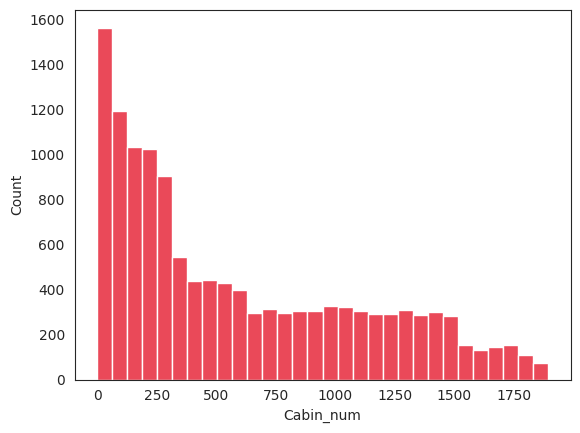

In [33]:
sns.histplot(df['Cabin_num'].astype(int), bins=30, kde=False, color=custom_colors[1])


In [34]:
df.loc[df['Cabin_side']=='-1', 'Cabin_side'] = np.random.choice(['S', 'P'], sum(df['Cabin_side']=='-1'), p=[0.5, 0.5])


In [35]:
df['Cabin_side'] = df['Cabin_side'].map({'S':0, 'P':1})


In [36]:
df['Cabin_side'].value_counts()


0    6525
1    6445
Name: Cabin_side, dtype: int64

In [37]:
df['Destination'].value_counts()


TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [38]:
df.loc[df['Destination'].isna(), 'Destination'] = np.random.choice(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'],
                                                                  sum(df['Destination'].isna()),
                                                                  p=[0.5, 0.3, 0.2])

<Axes: xlabel='Age', ylabel='Count'>

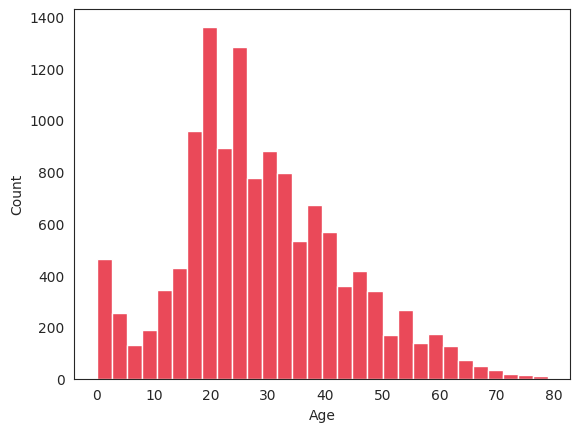

In [39]:
sns.histplot(df['Age'], bins=30, kde=False, color=custom_colors[1])


In [40]:
mean_age = df["Age"].mean()
std_age = df["Age"].std()
is_null = df["Age"].isnull().sum()
rand_sample = np.random.uniform(mean_age - std_age, mean_age + std_age, size = is_null)
df.loc[df['Age'].isna(), 'Age'] = rand_sample

In [41]:
df['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [42]:
df['VIP'].fillna(False, inplace=True)
df['VIP'] = df['VIP'].astype(int)

In [43]:
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in cols:
    df[col].fillna(df[col].median(), inplace=True)


In [44]:
df['total_spending'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] +\
df['Spa'] + df['VRDeck']


In [45]:
cols.append('total_spending')


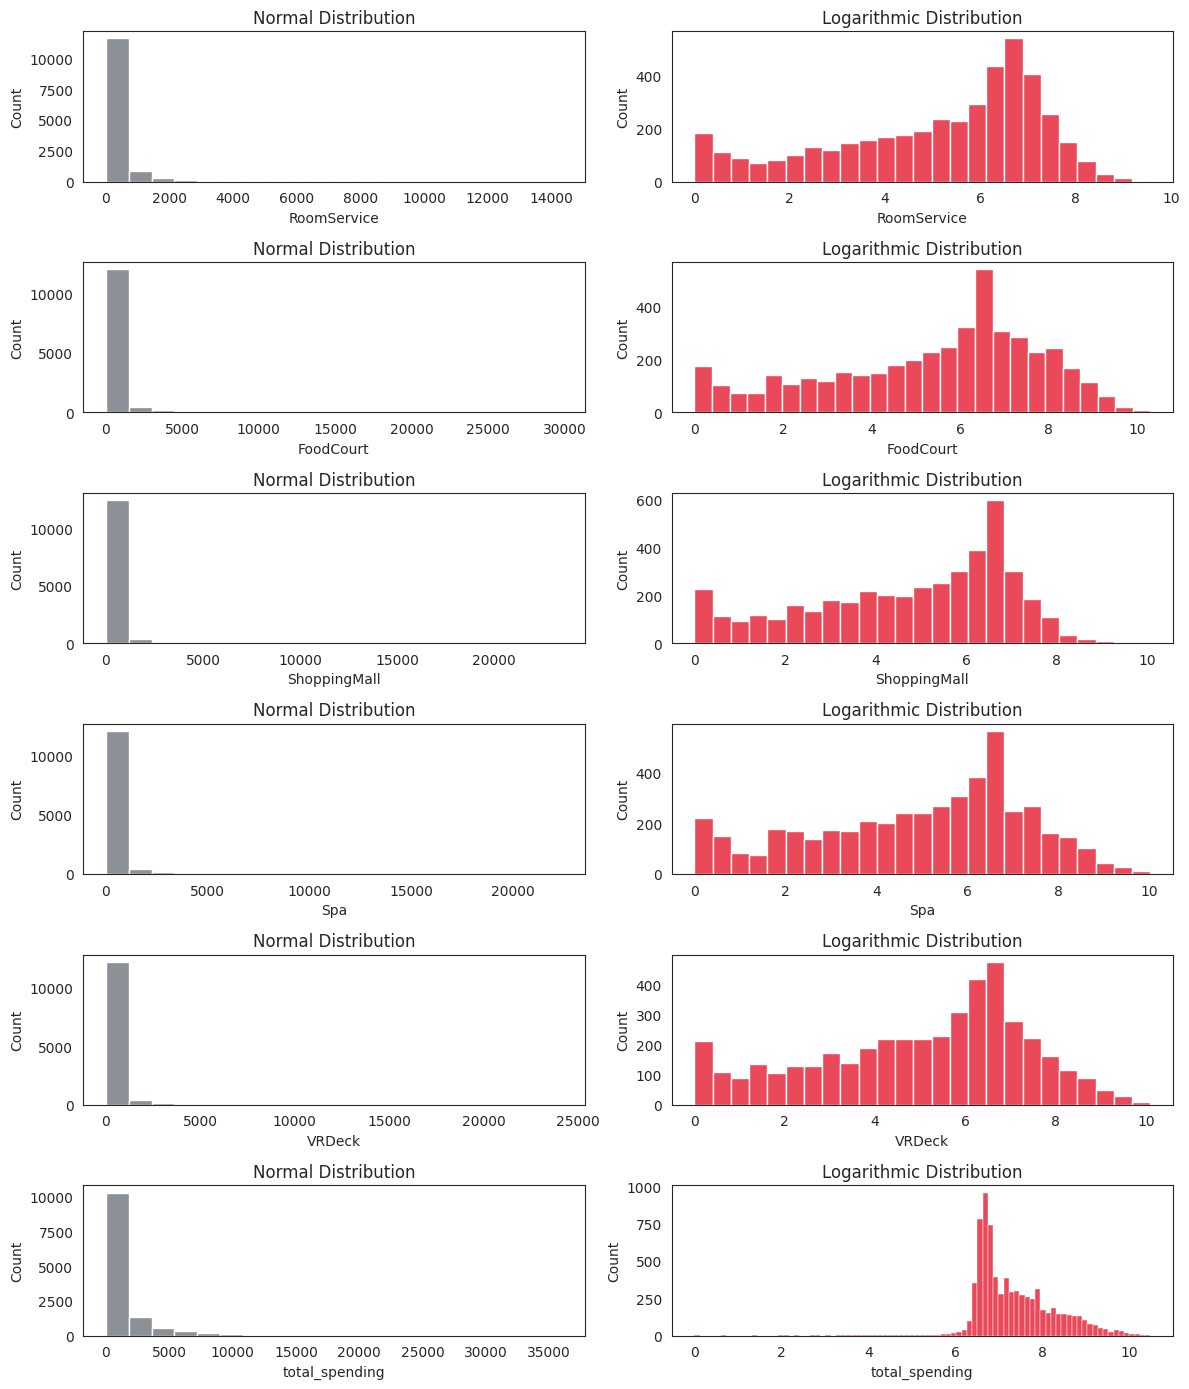

In [46]:
fig, axes = plt.subplots(len(cols),2, figsize=(12,14))
for i, col in enumerate(cols):
    sns.histplot(data=df, x=col, ax=axes[i, 0], bins=20, color=custom_colors[0])
    sns.histplot(data=np.log(df[[col]]), x=col, ax=axes[i, 1], color=custom_colors[1])
    axes[i, 0].set_title('Normal Distribution')
    axes[i, 1].set_title('Logarithmic Distribution')
plt.tight_layout()


In [47]:
for col in cols:
    df.loc[df[col]==0, col] = 0.367
    df[col] = np.log(df[col])

In [48]:
df['Name'].fillna('Unk Unk', inplace=True)

In [49]:
tmp = np.array(df['Name'].apply(lambda x: x if type(x)==float else x.split(' ')).to_list())

df['Name_first'] = tmp[:, 0]
df['Name_last'] = tmp[:, 1]

In [50]:
label_encoder = LabelEncoder()
df["Name_first"] = label_encoder.fit_transform(df.loc[:, "Name_first"])

label_encoder = LabelEncoder()
df["Name_last"] = label_encoder.fit_transform(df.loc[:, "Name_last"])

In [51]:
df.drop(columns="Name", inplace=True)

In [52]:
summary(df)

Dataset has 18 features and 12970 examples.


,Unique,Missing,Duplicated,Types
HomePlanet,3,0,0,object
CryoSleep,2,0,0,int64
Destination,3,0,0,object
Age,350,0,0,float64
VIP,2,0,0,int64
RoomService,1578,0,0,float64
FoodCourt,1953,0,0,float64
ShoppingMall,1367,0,0,float64
Spa,1679,0,0,float64
VRDeck,1642,0,0,float64


In [53]:
categorical_features = ['HomePlanet', 'Destination', 'Cabin_deck']
df = pd.concat([df, pd.get_dummies(df[categorical_features])], axis=1)
df.drop(columns=categorical_features, inplace=True)

<Axes: >

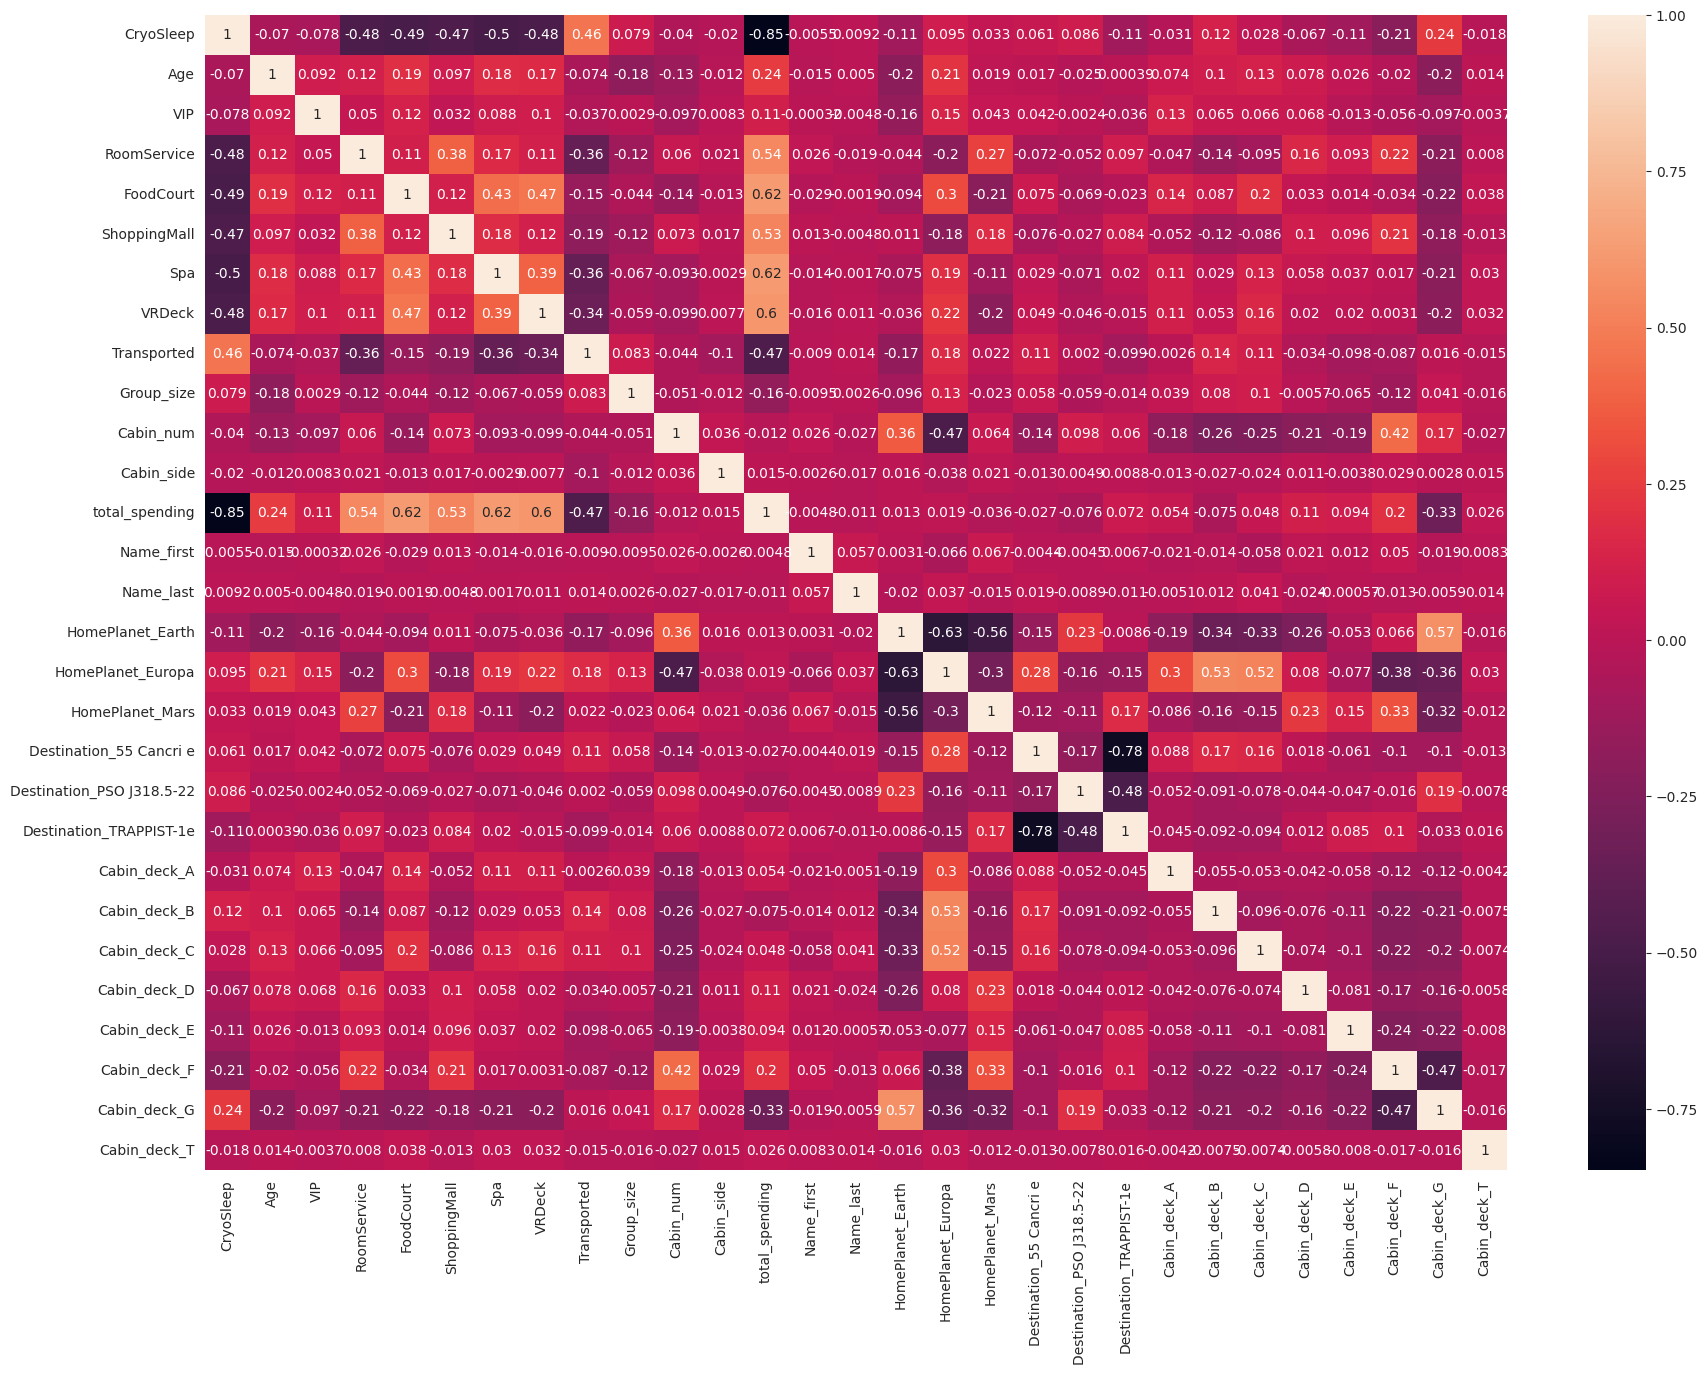

In [54]:
test_df  = df[train_df.shape[0]:]
train_df = df[:train_df.shape[0]]
corr = train_df.corr()
plt.figure(figsize=(21, 15))
sns.heatmap(corr, annot=True)

In [149]:
X = train_df.drop('Transported', axis=1)
y = train_df[['Transported']]
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.15, random_state=42)

In [56]:
X_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_size,Cabin_num,Cabin_side,total_spending,Name_first,Name_last,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5070_01,0,20.00,0,6.30,5.16,-1.00,1.61,-1.00,1,966,0,6.58,1639,488,1,0,0,0,1,0,0,0,0,0,0,1,0,0
5028_01,0,47.00,0,7.55,2.89,-1.00,4.49,8.39,1,61,0,8.77,964,1683,0,1,0,1,0,0,1,0,0,0,0,0,0,0
8656_02,0,38.00,1,-1.00,7.17,-1.00,7.52,7.34,3,103,0,8.45,131,1890,0,1,0,1,0,0,1,0,0,0,0,0,0,0
8232_01,0,19.00,0,1.61,6.50,-1.00,4.81,6.09,1,1574,0,7.12,895,1795,1,0,0,0,0,1,0,0,0,0,0,1,0,0
6906_03,1,7.00,0,-1.00,-1.00,-1.00,-1.00,-1.00,3,1432,1,-1.00,2355,1633,0,0,1,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6076_01,0,18.00,0,2.64,0.69,4.97,6.41,-1.00,1,988,0,6.65,2613,354,1,0,0,0,0,1,0,0,0,0,0,0,1,0
5537_01,0,50.00,0,6.54,-1.00,3.40,6.64,6.06,1,1063,0,7.55,1321,119,0,0,1,0,0,1,0,0,0,0,0,1,0,0
5756_06,0,22.00,0,5.06,-1.00,6.17,-1.00,3.26,8,1194,1,6.49,1517,271,1,0,0,0,1,0,0,0,0,0,0,1,0,0


In [57]:
clf_xgb = XGBClassifier('binary:logistic',
    colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=10,
                             min_child_weight=1.7817, n_estimators=1500,
                             reg_alpha=4.5, reg_lambda=8.5,
                             subsample=0.5213,
                             random_state=42)
clf_lgb = lgb.LGBMClassifier()
clf_cat = CatBoostClassifier(verbose=False)

x = X_train
y = y_train

cv_xgb = cross_val_score(clf_xgb, x, y, cv=5, scoring='accuracy').mean()
cv_lgbm = cross_val_score(clf_lgb, x, y, cv=5, scoring='accuracy').mean()
cv_cat = cross_val_score(clf_cat, x, y, cv=5, scoring='accuracy').mean()

clf_xgb.fit(x, y,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=25,
        verbose=False)

clf_lgb.fit(x, y,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=25,
        verbose=False)

clf_cat.fit(x, y,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=25,
        verbose=False)

y_pred_xgb = clf_xgb.predict(X_valid)
y_pred_lgbm = clf_lgb.predict(X_valid)
y_pred_cat = clf_cat.predict(X_valid)

KeyboardInterrupt: ignored

In [57]:
print("XGBoost CV Accuracy: ", cv_xgb)
print("LightGBM CV Accuracy: ", cv_lgbm)
print("CatBoost CV Accuracy: ", cv_cat)

XGBoost CV Accuracy:  0.8029496941373502
LightGBM CV Accuracy:  0.8087695590392331
CatBoost CV Accuracy:  0.8124239695172619


In [58]:
print('validation xgb score:', accuracy_score(y_pred_xgb, y_valid.values))
print('validation lgbm score:', accuracy_score(y_pred_lgbm, y_valid.values))
print('validation CatBoost score:', accuracy_score(y_pred_cat, y_valid.values))

validation xgb score: 0.8029141104294478
validation lgbm score: 0.8006134969325154
validation CatBoost score: 0.8067484662576687


In [59]:
X = train_df.drop('Transported', axis=1).copy()
y = train_df[['Transported']].copy()

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

X = X.values
y = y.values

In [60]:
best_params = {'learning_rate': 0.018049356549743555,
 'depth': 6,
 'l2_leaf_reg': 7.838880563296214,
 'border_count': 182,
 'verbose' : False}
final_model = CatBoostClassifier(**best_params)
final_model.fit(X, y)


In [61]:
!pip install XGBoost

In [62]:
import xgboost as xgb

In [63]:
params_XGB_best= {'lambda': 3.0610042624477543,
             'alpha': 4.581902571574289,
             'colsample_bytree': 0.9241969052729379,
             'subsample': 0.9527591724824661,
             'learning_rate': 0.06672065863100594,
             'n_estimators': 730, #initial value is 651
             'max_depth': 5,
             'min_child_weight': 1,
             'num_parallel_tree': 1}


In [69]:
from lightgbm import LGBMClassifier

In [9]:
!pip install optuna
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.5 MB/s eta 0:00:00


In [71]:
import optuna
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Define the objective function for Optuna for XGBoost
def objective_xgb(trial):
    params_xgb = {
        'lambda': trial.suggest_float('lambda', 1, 10),
        'alpha': trial.suggest_float('alpha', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree', 1, 5)
    }

    clf_xgb = XGBClassifier(**params_xgb)

    clf_xgb.fit(X_train, y_train)

    y_pred = clf_xgb.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)

    return accuracy

# Define the objective function for Optuna for CatBoost
def objective_cat(trial):
    params_cat = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 6),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 100, 200),
        'verbose': False
    }

    clf_cat = CatBoostClassifier(**params_cat)

    clf_cat.fit(X_train, y_train)

    y_pred = clf_cat.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)

    return accuracy

# Create an Optuna study for XGBoost
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)

# Get the best hyperparameters for XGBoost
best_params_xgb = study_xgb.best_params

# Create an Optuna study for CatBoost
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=50)

# Get the best hyperparameters for CatBoost
best_params_cat = study_cat.best_params

# Define the classifiers with the best hyperparameters
clf_xgb = XGBClassifier(**best_params_xgb)
clf_cat = CatBoostClassifier(**best_params_cat, verbose=False)

# Create the VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', clf_xgb),
    ('catboost', clf_cat)
], voting='soft')

# Fit the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Make predictions using the ensemble model
y_pred_ensemble = voting_clf.predict(X_valid)

# Evaluate the performance of the ensemble model
ensemble_accuracy = accuracy_score(y_valid, y_pred_ensemble)
print("Ensemble Accuracy:", ensemble_accuracy)


[I 2023-07-19 01:48:28,782] A new study created in memory with name: no-name-55fc1555-3cbb-47fe-8396-3641490fde82
[I 2023-07-19 01:49:08,457] Trial 0 finished with value: 0.8044478527607362 and parameters: {'lambda': 1.828420426008492, 'alpha': 1.5118722700821912, 'colsample_bytree': 0.9048237856517082, 'subsample': 0.5974631496899306, 'learning_rate': 0.04480827253676885, 'n_estimators': 523, 'max_depth': 6, 'min_child_weight': 4, 'num_parallel_tree': 5}. Best is trial 0 with value: 0.8044478527607362.
[I 2023-07-19 01:49:26,813] Trial 1 finished with value: 0.8044478527607362 and parameters: {'lambda': 8.385118742352592, 'alpha': 6.085064225975376, 'colsample_bytree': 0.8783909911595142, 'subsample': 0.9780000794266923, 'learning_rate': 0.08956268448241585, 'n_estimators': 744, 'max_depth': 3, 'min_child_weight': 3, 'num_parallel_tree': 4}. Best is trial 0 with value: 0.8044478527607362.
[I 2023-07-19 01:50:03,276] Trial 2 finished with value: 0.8029141104294478 and parameters: {'lam

Ensemble Accuracy: 0.803680981595092


In [150]:
import optuna
from catboost import CatBoostClassifier

# Define the objective function for Optuna for CatBoost
def objective_cat(trial):
    params_cat = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 6),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 100, 200),
        'verbose': False
    }

    clf_cat = CatBoostClassifier(**params_cat)

    clf_cat.fit(X_train, y_train)

    y_pred = clf_cat.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)

    return accuracy

# Create an Optuna study for CatBoost
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=99)

# Get the best hyperparameters for CatBoost
best_params_cat = study_cat.best_params

# Create the CatBoostClassifier with the best hyperparameters
clf_cat = CatBoostClassifier(**best_params_cat, verbose=False)

# Fit the CatBoostClassifier on the training data
clf_cat.fit(X_train, y_train)

# Make predictions using the CatBoost model
y_pred_cat = clf_cat.predict(X_valid)

# Evaluate the performance of the CatBoost model
catboost_accuracy = accuracy_score(y_valid, y_pred_cat)
print("CatBoost Accuracy:", catboost_accuracy)


[I 2023-07-19 03:07:12,492] A new study created in memory with name: no-name-7e4f2fc1-1613-441c-881e-f076e05f9b15
[I 2023-07-19 03:07:17,223] Trial 0 finished with value: 0.8103448275862069 and parameters: {'learning_rate': 0.023153970182954273, 'depth': 5, 'l2_leaf_reg': 8.061635825105085, 'border_count': 173}. Best is trial 0 with value: 0.8103448275862069.
[I 2023-07-19 03:07:21,022] Trial 1 finished with value: 0.7816091954022989 and parameters: {'learning_rate': 0.08631457024865306, 'depth': 6, 'l2_leaf_reg': 3.788873160817198, 'border_count': 104}. Best is trial 0 with value: 0.8103448275862069.
[I 2023-07-19 03:07:23,423] Trial 2 finished with value: 0.8045977011494253 and parameters: {'learning_rate': 0.07244184415022226, 'depth': 3, 'l2_leaf_reg': 9.360092427445025, 'border_count': 160}. Best is trial 0 with value: 0.8103448275862069.
[I 2023-07-19 03:07:26,078] Trial 3 finished with value: 0.7931034482758621 and parameters: {'learning_rate': 0.09764154670964438, 'depth': 4, '

CatBoost Accuracy: 0.8275862068965517


In [116]:
from sklearn.ensemble import VotingClassifier

# Define the classifiers
#clf_xgb = xgb.XGBClassifier(**params_XGB_best)
clf_lgbm = LGBMClassifier()
clf_cat = CatBoostClassifier(**best_params)

# Create the VotingClassifier
voting_clf = VotingClassifier(estimators=[
   # ('xgb', clf_xgb),
    ('lgbm', clf_lgbm),
    ('catboost', clf_cat)
], voting='soft')

# Fit the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Make predictions using the ensemble model
y_pred_ensemble = voting_clf.predict(X_valid)

# Evaluate the performance of the ensemble model
ensemble_accuracy = accuracy_score(y_valid, y_pred_ensemble)
print("Ensemble Accuracy:", ensemble_accuracy)


Ensemble Accuracy: 0.8090490797546013


In [151]:
from sklearn.metrics import classification_report
y_pred_ensemble = clf_cat.predict(X_valid)
# Calculate the classification report for the ensemble model
report = classification_report(y_valid, y_pred_ensemble)

# Print the classification report
print(report)


              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83        88
         1.0       0.81      0.85      0.83        86

    accuracy                           0.83       174
   macro avg       0.83      0.83      0.83       174
weighted avg       0.83      0.83      0.83       174



In [99]:
from sklearn.metrics import classification_report


In [152]:
pred = clf_cat.predict(test_df.drop(columns='Transported'))

In [153]:
sub = pd.read_csv('/content/sample_submission.csv')

In [154]:
sub['Transported'] = pred
sub['Transported'] = sub['Transported'].astype(bool)


In [155]:
sum(pred)


2196.0

In [156]:
sub


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [146]:
sub.to_csv('./submission_hp_cat.csv', index=False)

In [157]:
pred_cat = clf_cat.predict(test_df.drop(columns='Transported'))
sub['Transported'] = pred_cat
sub['Transported'] = sub['Transported'].astype(bool)
sub.to_csv('./submission8.csv', index=False)